<a href="https://colab.research.google.com/github/Hira63S/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Hira_DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

In [588]:
!pip install eli5

In [365]:
!pip install category_encoders

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [367]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


###Risk level highly seems like the leakage feature i.e. we already have pre-known information that would lead us to fail/pass the restaurant. 

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._





In [368]:
train['Violations'].isnull().sum()

9655

###Violations & Zip column
- seems to have a lot of null values and high cardinality, won't be using this feature.

In [369]:
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [370]:
train.columns.tolist()

['Inspection ID',
 'DBA Name',
 'AKA Name',
 'License #',
 'Facility Type',
 'Risk',
 'Address',
 'City',
 'State',
 'Zip',
 'Inspection Date',
 'Inspection Type',
 'Violations',
 'Latitude',
 'Longitude',
 'Location',
 'Fail']

In [460]:
train['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

In [376]:
X_train['Risk'].value_counts()

1    37731
3    10136
2     4037
4       12
Name: Risk, dtype: int64

###Defining X_train, X_test

In [0]:
features = ['DBA Name', 'Facility Type', 'Risk', 'Inspection Date', 'Inspection Type',
           'Violations', 'City']
target = 'Fail'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


Determining the majority class, 

In [591]:
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

0 is passing 1 is failing the inspection. 74%+ stores passed the inspection.

##Creating Baseline

In [0]:
majority_class = y_train.mode()[0] #which one happened the most
y_pred = [majority_class] * len(y_train) #fake predictions, we want to predict majority class
#over and over

In [593]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_pred)

0.5

as anticipated. above 0.5 would show that prediction is better than random guessing. 

In [594]:
X_train.isnull().sum().sort_values()

DBA Name              0
Inspection Date       0
Inspection Type       1
Risk                 12
Facility Type       224
Violations         9655
dtype: int64

Let's create a shallow tree as a baseline to find out the leaky feature.

In [0]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [0]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train[features])

In [598]:
#encoder = encoder 

pipeline = make_pipeline(
    StandardScaler(),    
    DecisionTreeClassifier(max_depth = 3)
)

pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_train)[:, 1]

roc_auc_score(y_train, y_pred_proba)

0.6681911271998658

###Visualize the tree to see which ones were most informative.

In [430]:
tree = DecisionTreeClassifier(max_depth =4)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

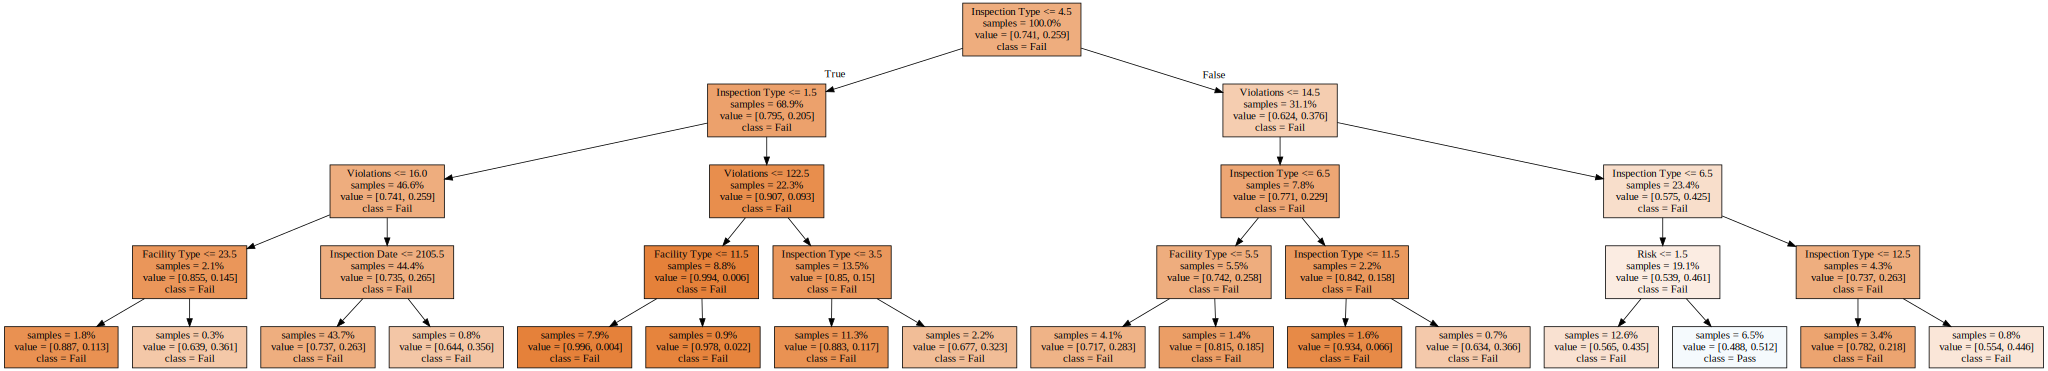

In [431]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, feature_names=X_train.columns, 
                           class_names=['Fail', 'Pass'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

- Inspection type seems to be the leakage feature as well as violation but the risk doesn't show up as previously anticipated. 

###Let's drop the inspection type feature and let's see if the roc_auc score drops. 

In [0]:
X_train = X_train.drop(columns = 'Violations')

X_test = X_test.drop(columns = 'Violations')

In [433]:
X_train.head()

,DBA Name,Facility Type,Risk,Inspection Date,Inspection Type
0,1,1,1,1,1
1,2,2,2,2,2
2,3,1,1,3,3
3,4,1,3,4,1
4,5,3,1,5,1


In [434]:
pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(max_depth = 3)
)

pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_train)[:, 1]

roc_auc_score = roc_auc_score(y_train, y_pred_proba)

print('ROC_AUC Sscore without Violation  is:', roc_auc_score)

ROC_AUC Sscore without Violation  is: 0.6635065039208986


In [435]:
tree = DecisionTreeClassifier(max_depth =4)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

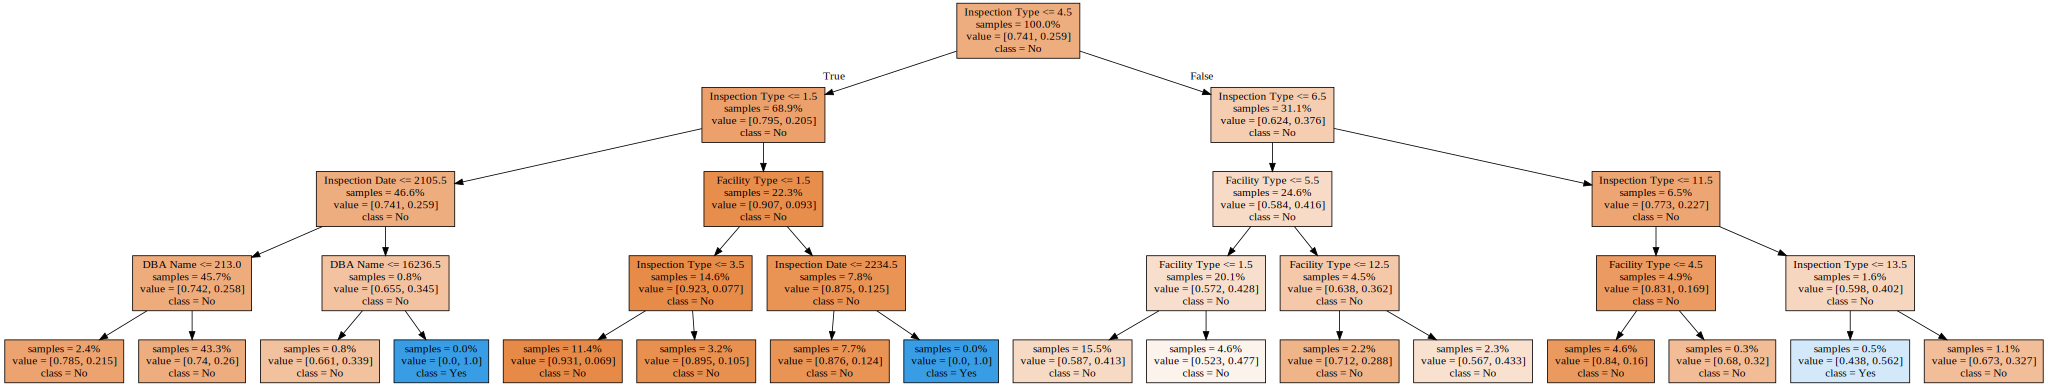

In [436]:
dot_data = export_graphviz(tree, out_file=None, feature_names=X_train.columns, 
                           class_names=['No', 'Yes'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

###Dropping the Violations feature leads to a roc_auc score of 0.6635 which is slightly lower than the previous roc_auc score where we had all the features.

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._



##Without the Risk feature

In [0]:
import numpy as np

In [0]:
train['Risk'] = train['Risk'].replace({'Risk 1 (High)':3, 'Risk 3 (Low)':1, 
                                   'Risk 2 (Medium)':2, np.nan:2})
 
test['Risk'] = test['Risk'].replace({'Risk 1 (High)':3, 'Risk 3 (Low)':1, 
                                   'Risk 2 (Medium)':2, np.nan:2})

features = ['Facility Type', 'Risk', 'Inspection Date', 'Inspection Type', 'Zip']
target = 'Fail'

X_train = train[features]
y_train = train[target]

X_test = test[features]

y_test = test[target]

In [0]:
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train[features])

In [679]:
param_distributions = {
    'n_estimators': [200], 
    'max_depth': [6, 7, 8]
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), #estimator = pipeline makes us put piepline in
    param_distributions=param_distributions, 
    n_iter=3, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   35.7s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   43.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=3, n_jobs=-1,
          param_distributions={'n_estimators': [200], 'max_depth': [6, 7, 8]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [680]:
print('Cross-Validation ROC_AUC score:', search.best_score_)

Cross-Validation ROC_AUC score: 0.6975181590493458


In [681]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.837951,0.327628,0.273008,0.006339,200,6,"{'n_estimators': 200, 'max_depth': 6}",0.695936,0.695080,0.701538,0.697518,0.002864,1,0.786010,0.783561,0.781910,0.783827,0.001684
1,8.471942,0.052613,0.319769,0.009951,200,7,"{'n_estimators': 200, 'max_depth': 7}",0.692202,0.691885,0.699119,0.694402,0.003338,2,0.816603,0.813781,0.811810,0.814065,0.001967
2,8.681995,1.253040,0.342087,0.029859,200,8,"{'n_estimators': 200, 'max_depth': 8}",0.689746,0.689311,0.694830,0.691296,0.002506,3,0.848584,0.841343,0.842125,0.844017,0.003245


In [684]:
best = search.best_estimator_
y_pred = best.predict_proba(X_test)[:,1]

print('Test ROC AUC:', roc_auc_score(y_test, y_pred))

Test ROC AUC: 0.5956379386689621


Seems too easy. I dropped the Risk feature and it gave me a high roc_auc score as well as a high test score.

The test score is almost at 0.60, let's see which were most important.

In [0]:
import matplotlib.pyplot as plt

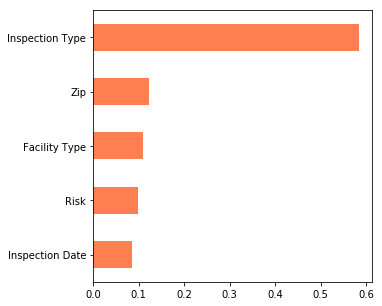

In [686]:
best.feature_importances_

figsize = (5,5)
importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()
plt.figure(figsize = figsize)
top_n.plot.barh(color = 'coral');

##Without the Violations feature

###Let's try dropping the violations feature. It makes sense that violations would be leakage feature as if they're coming in based on a complaint, there is a higher chance that the facility would fail the inspection.###

In [655]:
X_train.head()

,Facility Type,City,Risk,Inspection Type
0,1,1,1,1
1,2,1,2,2
2,1,1,1,3
3,1,1,3,1
4,3,1,1,1


In [0]:
features = ['Facility Type', 'City', 'Risk', 'Inspection Type']
target = 'Fail'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train[features])


In [0]:
encoder = ce.OrdinalEncoder()
X_test = encoder.fit_transform(X_test[features])

In [689]:
param_distributions = {
    'n_estimators': [200], 
    'max_depth': [6,7]
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), #estimator = pipeline makes us put piepline in
    param_distributions=param_distributions, 
    n_iter=4, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=3, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   11.0s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   17.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=4, n_jobs=-1,
          param_distributions={'n_estimators': [200], 'max_depth': [6, 7]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

##Cross-validation scores with and without Inspection Type

##Cross Validation socre with and without Risk 

In [502]:
from sklearn.model_selection import cross_val_score

X_train_Risk = X_train.drop(columns='Risk')
new_model = XGBClassifier(max_depth=2, n_estimators=200, n_jobs=-1, random_state=42)

score_with = cross_val_score(new_model, X_train, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC with Risk:', score_with)

#use cross_val_score with XGBClassifier

score_without = cross_val_score(new_model, X_train_Risk, y_train, cv=2, scoring='roc_auc').mean()
print('Cross-Validation ROC AUC without Risk:', score_without)

print('Drop-Column Importance:', score_with - score_without)

Cross-Validation ROC AUC with Risk: 0.671420469126941
Cross-Validation ROC AUC without Risk: 0.66746286922413
Drop-Column Importance: 0.003957599902810971


#Generating feature

- taking in risk feature and making columns based on the risk level

In [505]:
train['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

In [506]:
 #train['Risk'] = X['Risk'].str.lower()
train['High_risk'] = train['Risk'].str.contains('Risk 1 (High)', na=False)
train['Low_risk'] = train['Risk'].str.contains('Risk 3 (Low)', na=False)
train['Medium Risk']   = train['Risk'].str.contains('Risk 2 (Medium)', na=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [507]:
test['High_risk'] = test['Risk'].str.contains('Risk 1 (High)', na=False)
test['Low_risk'] = test['Risk'].str.contains('Risk 3 (Low)', na=False)
test['Medium Risk']   = test['Risk'].str.contains('Risk 2 (Medium)', na=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


###Modeling with the new features

In [509]:
features = ['Facility Type', 'Risk', 'Inspection Date',
           'Inspection Type', 'High_risk', 'Low_risk', 'Medium Risk', 'Zip']
target = 'Fail'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train[features])

encoder = ce.OrdinalEncoder()
X_test = encoder.fit_transform(X_test[features])

param_distributions = {
    'n_estimators': randint(50, 300), 
    'max_depth': randint(2, 5)
}

# n_iter & cv parameters are low here so the example runs faster
search = RandomizedSearchCV(
    estimator=XGBClassifier(n_jobs=-1, random_state=42), #estimator = pipeline makes us put piepline in
    param_distributions=param_distributions, 
    n_iter=4, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=4, 
    verbose=10, 
    return_train_score=True, 
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   36.2s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=4, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb8480f55c0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb84970ad68>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [361]:
print('Cross-Validation ROC_AUC score:', search.best_score_)

from sklearn.metrics import roc_auc_score
best = search.best_estimator_
y_pred_proba = best.predict_proba(X_test.values)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Cross-Validation ROC_AUC score: 0.6997829647663186
Test ROC AUC: 0.5948906824385252


Ran out of time to finish this.

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._


In [631]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(best, scoring='roc_auc', cv='prefit',
                     n_iter=2, random_state=42) 
#the first argument is you pass in the estimator

permuter.fit(X_test.values, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=229,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
           n_iter=2, random_state=42, refit=True, scoring='roc_auc')

In [632]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names = feature_names)

Weight,Feature
0.0794 ± 0.0191,Inspection Type
0.0045 ± 0.0019,Risk
0.0021 ± 0.0006,Inspection Date
0.0011 ± 0.0065,Facility Type
0.0003 ± 0.0001,City


### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

Gradient Descent attempts to minimize the output given inputs.  It helps in finding the minimum of a certain function. In Linear Regression, it is used to minimize the squared error cost function.

Learning rate is multiple of the gradient. It is also called alpha sometimes, often a small positive value.
It is a hyper-paremeter that controls how much we adjust to the change in input i.e. the smaller the value the slower we move downwards and slower do we get to the minimum of any function.

#Ordinal Encoding#

- In this case here, the documentation does not identify which one is the best or the worst kind of Inspection. So, here it is using a single column of integers to represent the classes. 
- However, you can pass in a mapping dictionary like, for example in Risk column, you could pass in High risk is 1, medium-risk is 2, and low-risk is 3. But the preconception here is that there is smoe true order to classes themselves. 
